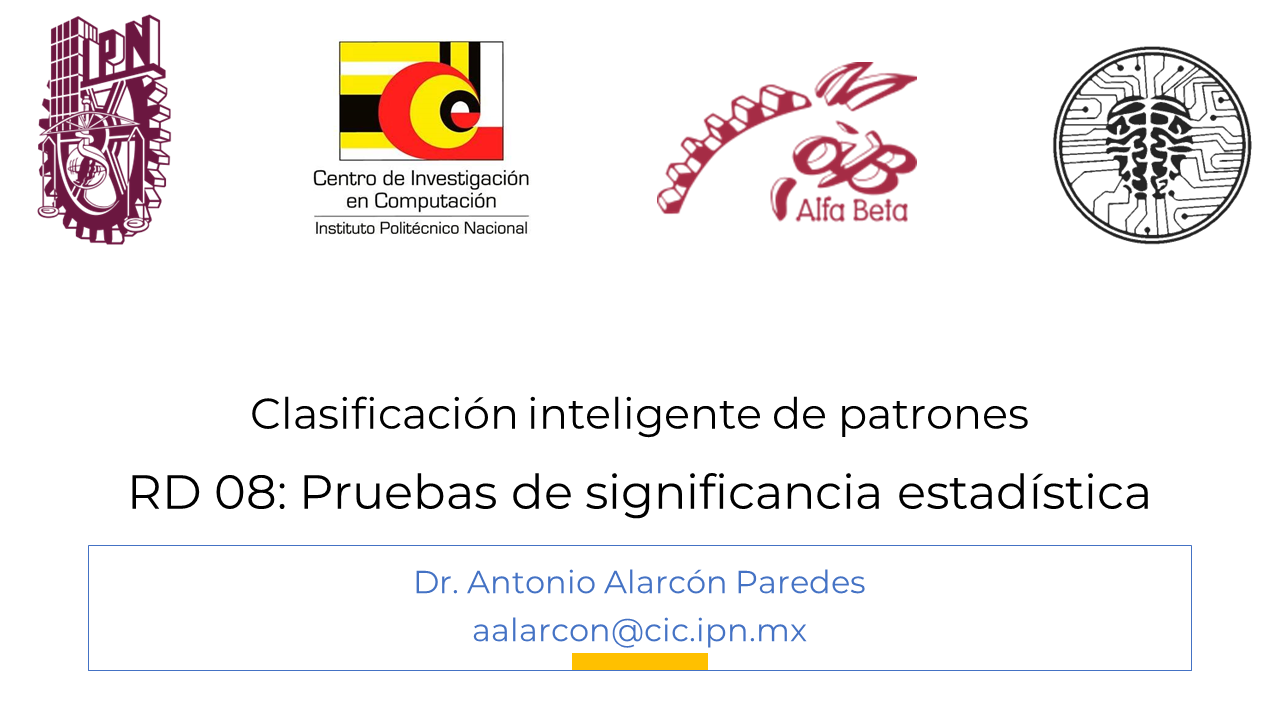

## Cargar librerías y funciones...

In [2]:
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
#from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix, f1_score, roc_auc_score
from imblearn.metrics import sensitivity_score, specificity_score, geometric_mean_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import datasets
from random import *


def classevaluation(y_test, y_pred):
    k = len(set(y_test))
    if k==2:
      avg = 'binary'
      multi = 'raise'
    else:
      avg = 'macro'
      multi = 'ovr'

    acc = accuracy_score(y_test,y_pred)
    sen = sensitivity_score(y_test,y_pred, average=avg)
    spe = specificity_score(y_test,y_pred, average=avg)
    f1s = f1_score(y_test,y_pred, average=avg)
    gmean = geometric_mean_score(y_test,y_pred, average=avg)
    auc = roc_auc_score(y_test,y_pred,multi_class=multi)

    return acc, sen, spe, f1s, gmean, auc


### Cargar y graficar datos

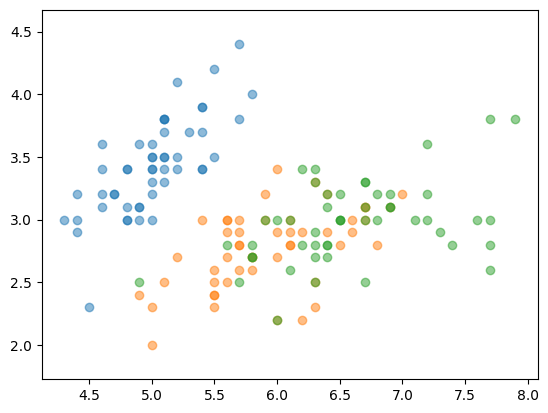

In [3]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

plt.scatter(X[y==0, 0], X[y==0, 1], alpha=0.5);
plt.scatter(X[y==1, 0], X[y==1, 1], alpha=0.5);
plt.scatter(X[y==2, 0], X[y==2, 1], alpha=0.5);
plt.axis('equal');
plt.show()

## Mann-Whitney
La prueba de Mann-Whitney se aplica para dos muestras independientes. Se trata de una prueba no paramétrica con una hipótesis nula de que la distribución de la muestra A es la misma que la distribución de la muestra B.

Por ejemplo para un problema de clasificación, Mann-Whitney puede emplearse para identificar los atributos de un dataset con valor de p menor (o con un p significativo), se ordenan de acuerdo con ello. Esto significaría que los valores de una clase en dicho atributo difieren significativamente de los valores de la otra clase para el mismo atributo. Es decir, ese atributo puede aportar información valiosa para separar las clases.


### Individualmente
Se obtiene el resultado de clasificar los features individualmente en el iris dataset.

Statistics=878.0000000000, p=0.0000567533
Feature 0: REJECT H0
Statistics=720.5000000000, p=0.0401911255
Feature 1: REJECT H0
Statistics=1102.0000000000, p=0.0000000000
Feature 2: REJECT H0
Statistics=1097.0000000000, p=0.0000000000
Feature 3: REJECT H0

Indices ordenados: [2 3 0 1]
Valores ordenados: [7.71502805e-12 1.06982729e-11 5.67533054e-05 4.01911255e-02]



----------CLASIFICACIÓN EN FEATURES INDIVIDUALES----------

Feature 2: petal length (cm), p = 7.715028045155831e-12
Accuracy: 0.8484848484848485
Sensitivity: 0.9473684210526315
Specificity: 0.7142857142857143
F1-Score: 0.8780487804878049
G-mean: 0.8226127456606226
AUC: 0.8308270676691729

Feature 3: petal width (cm), p = 1.0698272922070137e-11
Accuracy: 0.9393939393939394
Sensitivity: 1.0
Specificity: 0.8571428571428571
F1-Score: 0.9500000000000001
G-mean: 0.9258200997725514
AUC: 0.9285714285714286

Feature 0: sepal length (cm), p = 5.675330540058706e-05
Accuracy: 0.6666666666666666
Sensitivity: 0.5789473684210527
Specificit

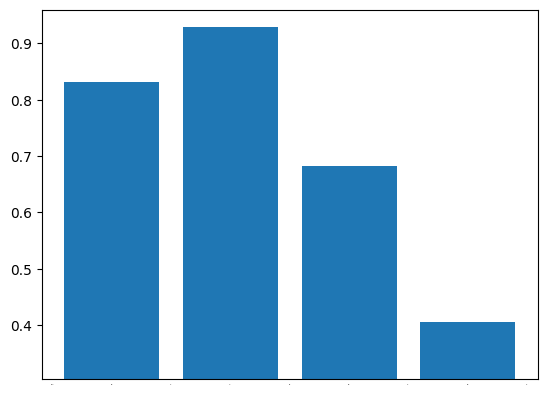

['petal length (cm)', 'petal width (cm)', 'sepal length (cm)', 'sepal width (cm)']




In [4]:
data = datasets.load_iris()
yy = data.target
X = data.data[yy!=0,:]
y = data.target[yy!=0] #Para tomar las clases 1 y 2
y[y==2]=0 # A la clase 2 se le renombra como clase 0
patterns, features = X.shape

# data = datasets.load_breast_cancer()
# X = data.data
# y = data.target
# patterns, features = X.shape

# Algoritmo de clasificación
mdl = KNeighborsClassifier()
# mdl = RandomForestClassifier()
# mdl = SVC()

# Validación: Hold-out
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=42)

# Aplicar Mann-Whitney
stat=[]
p=[]
for i in range(0, features):
    aux_stat, aux_p = st.mannwhitneyu(X_train[y_train==0, i], X_train[y_train==1, i])
    stat.append(aux_stat)
    p.append(aux_p)
    print('Statistics=%.10f, p=%.10f' % (aux_stat, aux_p))
    # interpret
    alpha = 0.05
    if aux_p > alpha:
      print('Feature {i}: Fail to reject H0)')
    else:
      print(f'Feature {i}: REJECT H0')
    
p=np.array(p)
p_id = np.argsort(p)
p_sort = np.sort(p)
print(f'\nIndices ordenados: {p_id}')
print(f'Valores ordenados: {p_sort}\n')

aucs=[]
names=[]
print('\n\n----------CLASIFICACIÓN EN FEATURES INDIVIDUALES----------\n')
# Entrenar el clasificador en features individuales
for idx in p_id:
    mdl.fit(X_train[:,idx].reshape(-1, 1), y_train)
    # Obtener predicción
    y_pred = mdl.predict(X_test[:,idx].reshape(-1, 1))
    acc, sen, spe, f1s, gmean, auc = classevaluation(y_test, y_pred)
    aucs.append(auc)
    names.append(data.feature_names[idx])
    print(f'Feature {idx}: {data.feature_names[idx]}, p = {p[idx]}')
    print(f'Accuracy: {acc}')
    print(f'Sensitivity: {sen}')
    print(f'Specificity: {spe}')
    print(f'F1-Score: {f1s}')
    print(f'G-mean: {gmean}')
    print(f'AUC: {auc}\n')

bot = np.min(aucs) - (np.min(aucs)/4)
plt.bar(np.sort(p_id), aucs-bot, bottom=bot)
plt.tick_params(axis='x', labelsize=0, length = 0)
plt.show()
print(f'{names}\n\n')




### Acumulativo

En este ejemplo, se aplica Mann-Whitney para identificar los features con valor de p menor, se ordenan de acuerdo con ello.

Se obtiene el resultado de clasificar de forma acumulativa los features ordenados en el dataset.


Indices ordenados: [2 3 0 1]
Valores ordenados: [7.71502805e-12 1.06982729e-11 5.67533054e-05 4.01911255e-02]



----------CLASIFICACIÓN EN FEATURES ACUMULATIVA----------

Features: [2], p = [7.71502805e-12]
Accuracy: 0.8787878787878788
Sensitivity: 0.8947368421052632
Specificity: 0.8571428571428571
F1-Score: 0.8947368421052632
G-mean: 0.875738141931184
AUC: 0.8759398496240602

Features: [2, 3], p = [7.71502805e-12 1.06982729e-11]
Accuracy: 0.8484848484848485
Sensitivity: 0.9473684210526315
Specificity: 0.7142857142857143
F1-Score: 0.8780487804878049
G-mean: 0.8226127456606226
AUC: 0.8308270676691729

Features: [2, 3, 0], p = [7.71502805e-12 1.06982729e-11 5.67533054e-05]
Accuracy: 0.8787878787878788
Sensitivity: 0.9473684210526315
Specificity: 0.7857142857142857
F1-Score: 0.9
G-mean: 0.8627635262664034
AUC: 0.8665413533834585

Features: [2, 3, 0, 1], p = [7.71502805e-12 1.06982729e-11 5.67533054e-05 4.01911255e-02]
Accuracy: 0.9090909090909091
Sensitivity: 0.9473684210526315
Specific

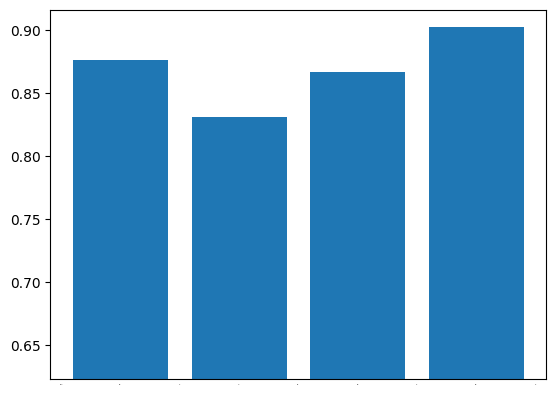

['petal length (cm)', 'petal width (cm)', 'sepal length (cm)', 'sepal width (cm)']




In [ ]:
data = datasets.load_iris()
yy = data.target
X = data.data[yy!=0,:]
y = data.target[yy!=0] #Para tomar las clases 1 y 2
y[y==2]=0 # A la clase 2 se le renombra como clase 0
patterns, features = X.shape

# data = datasets.load_breast_cancer()
# X = data.data
# y = data.target
# patterns, features = X.shape

# Algoritmo de clasificación
# mdl = KNeighborsClassifier()
# mdl = RandomForestClassifier()
mdl = SVC()

# Validación: Hold-out
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=42)

# Aplicar Mann-Whitney
stat=[]
p=[]
for i in range(0, features):
    aux_stat, aux_p = st.mannwhitneyu(X_train[y_train==0, i], X_train[y_train==1, i])
    stat.append(aux_stat)
    p.append(aux_p)
    
p=np.array(p)
p_id = np.argsort(p)
p_sort = np.sort(p)
print(f'\nIndices ordenados: {p_id}')
print(f'Valores ordenados: {p_sort}\n')

print('\n\n----------CLASIFICACIÓN EN FEATURES ACUMULATIVA----------\n')
# Entrenar el clasificador
f_acum=[]
aucs=[]
for idx in p_id:
    f_acum.append(idx)
    if len(f_acum) == 1:
      mdl.fit(X_train[:,f_acum].reshape(-1, 1), y_train)
      # Obtener predicción
      y_pred = mdl.predict(X_test[:,f_acum].reshape(-1, 1))
    else:
      mdl.fit(X_train[:,f_acum], y_train)
      # Obtener predicción
      y_pred = mdl.predict(X_test[:,f_acum])
    acc, sen, spe, f1s, gmean, auc = classevaluation(y_test, y_pred)
    aucs.append(auc)
    print(f'Features: {f_acum}, p = {p[f_acum]}')
    print(f'Accuracy: {acc}')
    print(f'Sensitivity: {sen}')
    print(f'Specificity: {spe}')
    print(f'F1-Score: {f1s}')
    print(f'G-mean: {gmean}')
    print(f'AUC: {auc}\n')

bot = np.min(aucs) - (np.min(aucs)/4)
plt.bar(np.sort(f_acum), aucs-bot, bottom=bot)
plt.tick_params(axis='x', labelsize=0, length = 0)
plt.show()
print(f'{names}\n\n')




## Kruskal-Wallis

Aquí se calcula la prueba de Kruskal-Wallis para muestras independientes. En ésta se establece la hipótesis nula de que la mediana de la población de todos los grupos analizados es la misma. Es la versión NO paramétrica de ANOVA. Puede aplicarse a dos o más muestras independientes, y pueden ser de diferente tamaño.

Si en la prueba se rechaza la hipótesis nula, no es posible determinar cuál (o cuáles) de las muestras es la que difiere de las demás. Para esto, se requeriría llevar a cabo una prueba Post hoc, y así determinar cuál muestra es diferente.

Para este ejemplo retomamos los datos de una tarea de habilidades psicomotrices de expertos en laparoscopía, así como de no expertos, en un entrenador laparoscópico.

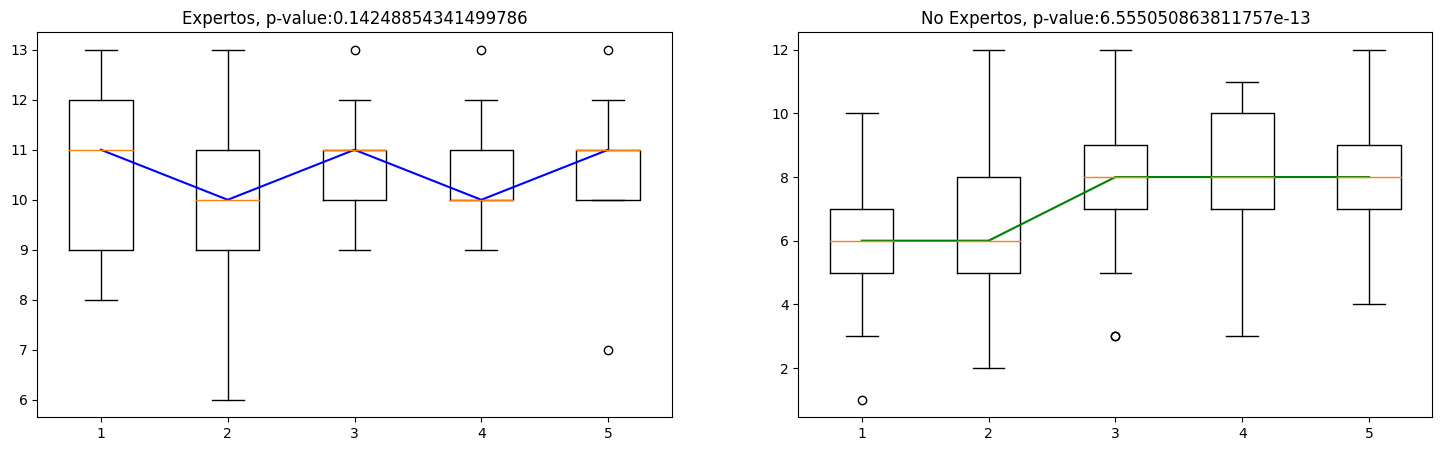

In [ ]:
Ex = np.genfromtxt('Expertos.csv', delimiter=',')
NEx = np.genfromtxt('No Expertos.csv', delimiter=',')

mEx = np.median(Ex, axis=0)
mNEx = np.median(NEx, axis=0)

#print(Ex)
#print(NEx)

stat, p = st.kruskal(Ex[:,0], Ex[:,1], Ex[:,2], Ex[:,3], Ex[:,4])
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.boxplot(Ex)
plt.plot([1,2,3,4,5],mEx,'b')
plt.title(f'Expertos, p-value:{p}')

stat, p = st.kruskal(NEx[:,0], NEx[:,1], NEx[:,2], NEx[:,3], NEx[:,4])
plt.subplot(122)
plt.boxplot(NEx)
plt.plot([1,2,3,4,5],mNEx, 'g')
plt.title(f'No Expertos, p-value:{p}')
plt.show()


## Friedman

Se aplica la prueba de Friedman para muestras repetidas. Ésta establece la hipótesis nula de que las muestras con repetición vienen de la misma distribución.

Aquí se aplica la prueba de Friedman para identificar diferencias significativas en el desempeño de algoritmos de clasificación.
<br>
<!-- Para este ejemplo se tomaron en cuenta un total de 9 algoritmos de clasificación, y 11 conjuntos de datos de microarreglos, y se utilizó la F-measure como medida de rendimiento. -->
Para este ejemplo se tomaron en cuenta un total de 5 algoritmos de clasificación, y 11 conjuntos de datos de microarreglos, y se utilizó la F-measure como medida de rendimiento.
<br>
Algoritmos: FCW, FCW-3, TraditionalWrapper, BCO-KNN, IG-GA-KNN
<!-- Algoritmos: FCW, FCW-3, FCW-5, FCW-10, TraditionalWrapper, BCO-KNN,IG-GA-KNN, TGA-KNNV, SRKNN -->
<br>
Datos: 9tumors, 11tumors, 14tumors, Braintumor1, Braintumor2, DLBCL, Leukemia1, Leukemia2, Lung cancer, Prostate tumor, SRBCT.

In [ ]:
# fmeas = np.genfromtxt('F-Measure.csv', delimiter=',')
fmeas = np.genfromtxt('F1-Score.csv', delimiter=',')
print(f'F-Measure:\n{fmeas}')
fmeas = 100 - fmeas
# classifiers = ['FCW', 'FCW-3', 'FCW-5', 'FCW-10', 'TraditionalWrapper', 
#                'BCO-KNN', 'IG-GA-KNN', 'TGA-KNNV', 'SRKNN']
classifiers = ['FCW', 'TraditionalWrapper', 'BCO-KNN', 'IG-GA-KNN', 'SRKNN']

# p = st.friedmanchisquare(fmeas[:,0], fmeas[:,1], fmeas[:,2], fmeas[:,3],
#                                 fmeas[:,4], fmeas[:,5], fmeas[:,6], fmeas[:,7],
#                                 fmeas[:,8]);
p = st.friedmanchisquare(fmeas[:,0], fmeas[:,1], fmeas[:,2],
                         fmeas[:,3], fmeas[:,4]);

print(f'\np-value: {p.pvalue}\n')

rank = st.mstats.rankdata(fmeas,axis=1)
mrank = np.average(rank,axis=0)
rank_id = np.argsort(mrank)
rank_sort = np.sort(mrank)

print(f'Tabla de ranking en algoritmos:\n{rank}')
print(f'\nMean-ranks:')
print(mrank)

print('\nClasificador\t\t\tRanking')
for idx in rank_id:
    print(f'{classifiers[idx]} \t\t {mrank[idx]}')




F-Measure:
[[ 86.14  75.    92.22  85.    43.  ]
 [ 95.95  89.08  89.62  92.53  84.  ]
 [ 81.28  76.3   67.64  65.26  69.  ]
 [ 96.15  93.33  96.3   93.33  85.  ]
 [100.   100.   100.    88.    74.  ]
 [100.    98.7  100.   100.    97.  ]
 [100.   100.   100.   100.    94.  ]
 [100.   100.   100.    98.61  92.  ]
 [ 99.5   98.52  99.34  95.57  77.  ]
 [ 98.04  94.12 100.    96.08  91.  ]
 [100.    96.39 100.   100.    98.  ]]

p-value: 1.4843707807533642e-05

Tabla de ranking en algoritmos:
[[2.  4.  1.  3.  5. ]
 [1.  4.  3.  2.  5. ]
 [1.  2.  4.  5.  3. ]
 [2.  3.5 1.  3.5 5. ]
 [2.  2.  2.  4.  5. ]
 [2.  4.  2.  2.  5. ]
 [2.5 2.5 2.5 2.5 5. ]
 [2.  2.  2.  4.  5. ]
 [1.  3.  2.  4.  5. ]
 [2.  4.  1.  3.  5. ]
 [2.  5.  2.  2.  4. ]]

Mean-ranks:
[1.77272727 3.27272727 2.04545455 3.18181818 4.72727273]

Clasificador			Ranking
FCW 		 1.7727272727272727
BCO-KNN 		 2.0454545454545454
IG-GA-KNN 		 3.1818181818181817
TraditionalWrapper 		 3.272727272727273
SRKNN 		 4.7272727272727275
